In [147]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import random

import matplotlib.pyplot as plt

%matplotlib inline

seed=122334445
np.random.seed(seed)
random.seed(seed)

In [2]:
header = ['Mcg', 'Gvh', 'Alm', 'Mit', 'Erl', 'Pox', 'Vac', 'Nuc', 'class']
df = pd.read_csv('data/yeast-2_vs_4.dat', names=header, skiprows=13)
print(df.head())
df['class'] = df['class'].apply(lambda x:0 if x=='negative' else 1)

df_np = df.to_numpy()
x = df_np[:,:-1]
y = df_np[:,-1]

x = (x - x.mean(axis=0)) / x.var(axis=0)

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

ensemble_sizes = [10, 50, 100]

print('Dataset X shape:', x.shape)
print('Dataset Y shape:', y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

    Mcg   Gvh   Alm   Mit  Erl  Pox   Vac   Nuc     class
0  0.51  0.40  0.56  0.17  0.5  0.5  0.49  0.22  negative
1  0.40  0.39  0.60  0.15  0.5  0.0  0.58  0.30  negative
2  0.40  0.42  0.57  0.35  0.5  0.0  0.53  0.25  negative
3  0.46  0.44  0.52  0.11  0.5  0.0  0.50  0.22  negative
4  0.47  0.39  0.50  0.11  0.5  0.0  0.49  0.40  negative
Dataset X shape: (514, 8)
Dataset Y shape: (514,)
x_train shape: (462, 8)
y_train shape: (462,)
x_test shape: (52, 8)
y_test shape: (52,)


In [3]:
class AdaBoostM2:
    def __init__(self, x, y, n_classifier, base=None, weights=None, **kwargs):
        """
        Initialize AdaBoost M2 (Weight init is same as M1)
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        
        :return: A AdaBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
        
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones(len(self.x)) / len(self.x)
            
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10 
        return np.argmax(p, axis=1)
    
    
    def fit(self):
        """
        Train the ensemble using base weak classifiers
        """
        for t in range(self.n_classifier):            
            
            # training weak classifier
            self.classifiers[t].fit(self.x, self.y, sample_weight=self.weights)
                        
            # calculating loss = sum of missclassified weights
            miss_w = self.weights[(self.classifiers[t].predict(self.x) != self.y).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop classifiers with acc < 0.5
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
#             print(a, self.n_classifier, self.classifiers[t].score(self.x, self.y))
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(self.x) == self.y).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
             
    
    def score(self, x, y):
        p = self.predict(x)
        return np.sum((p == y)*1) / len(y)   

# Test
# model = AdaBoostM2(x=x_train, y=y_train, n_classifier=100, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [154]:
adaboost_accuracies = []  # accuracies of different ensembles given 5 folds
adaboost_pr = []  # precision-recall of different ensebmles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    kf_pr = []  # precision-recall of 5 folds
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = AdaBoostM2(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
    adaboost_pr.append(kf_pr)
    adaboost_accuracies.append(kf_acc)
for idx,f in enumerate(adaboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(adaboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.95145631067961167, 0.91262135922330101, 0.970873786407767, 0.96116504854368934, 0.90196078431372551] ---> AVG=0.9396154578336189
Accuracy of ensemble with size of #50:
 [0.95145631067961167, 0.91262135922330101, 0.970873786407767, 0.96116504854368934, 0.90196078431372551] ---> AVG=0.9396154578336189
Accuracy of ensemble with size of #100:
 [0.95145631067961167, 0.91262135922330101, 0.970873786407767, 0.96116504854368934, 0.90196078431372551] ---> AVG=0.9396154578336189


In [5]:
class RUSBoost:
    def __init__(self, x, y, n_classifier, base=None, weights=None, **kwargs):
        """
        Initialize RUSBoost
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        
        :return: A RUSBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
        
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones((len(self.x))) / len(self.x)
            
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10
        return np.argmax(p, axis=1)
    
    
    def fit(self):
        """
        Train the ensemble using RUS data boosting and base weak classifiers
        """
        for t in range(self.n_classifier):            
            # random under sampling
            rus_idx = self.__undersample()

            # training weak classifier
            self.classifiers[t].fit(self.x[rus_idx], self.y[rus_idx], self.weights[rus_idx])
            
            # calculating loss = sum of missclassified weights            
            miss_w = self.weights[(self.classifiers[t].predict(self.x) != self.y).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop bad classifiers
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
            
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(self.x) == self.y).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
             
    
    def score(self, x, y):
        p = self.predict(x)
        return (p == y).nonzero()[0].__len__() / len(y)
           
    def __undersample(self):
        """
        Generates a random unique subset of majority data as same size as minority and return the indices
        
        :return: A sorted list of indices with shape of (2*minority_data, )
        """
        pos_size = len((self.y==1).nonzero()[0])
        neg_size = len((self.y==0).nonzero()[0])
        pos_data = self.x[self.y==1]
        neg_data = self.x[self.y==0]
        
        if pos_size > neg_size:
            self.major_data = pos_data
            self.minor_data = neg_data
            self.minor = 0
        else:
            self.minor_data = pos_data
            self.major_data = neg_data
            self.minor = 1
        # getting index of sampled intances for enabling correct weight update
        minor_idx = (self.y == self.minor).nonzero()[0]
        major_idx = (self.y == int(not self.minor)).nonzero()[0]
        major_idx = np.array(random.sample(list(major_idx), len(self.minor_data)))
        return sorted(np.concatenate((minor_idx, major_idx)))
    
# test
# model = RUSBoost(x=x_train, y=y_train, n_classifier=30, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [156]:
rusboost_accuracies = []  # accuracies of different ensembles given 5 folds
rusboost_pr = []
for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RUSBoost(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
    rusboost_pr.append(kf_pr)
    rusboost_accuracies.append(kf_acc)
for idx,f in enumerate(rusboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(rusboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.92233009708737868, 0.93203883495145634, 0.93203883495145634, 0.970873786407767, 0.93137254901960786] ---> AVG=0.9377308204835332
Accuracy of ensemble with size of #50:
 [0.94174757281553401, 0.93203883495145634, 0.99029126213592233, 0.970873786407767, 0.92156862745098034] ---> AVG=0.951304016752332
Accuracy of ensemble with size of #100:
 [0.93203883495145634, 0.92233009708737868, 0.970873786407767, 0.98058252427184467, 0.91176470588235292] ---> AVG=0.94351798972016


In [7]:
class SMOTEBoost:
    def __init__(self, x, y, n_classifier, k=5, smote_ratio=100, base=None, weights=None, **kwargs):
        """
        Initialize AdaBoost M2 (Weight init is same as M1)
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        :param smote_ratio: the ratio of smoteing data
        :param k: number of nearest neighbors in SMOTE
        
        :return: A SMOTEBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.smote_ratio = smote_ratio  # alias N
        self.k = k
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.newindex = 0  # to count SMOTEed samples
        self.synthetic = []  # SMOTEed samples
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
            
    def __SMOTE(self):
        """
        Applies SMOTE on data
        
        :return: SMOTEed data in shape of (N*T/100)
        """
        
        self.synthetic = []  # reinit synthetic for new SMOTEing
        
        pos_size = len((self.y==1).nonzero()[0])
        neg_size = len((self.y==0).nonzero()[0])
        pos_data = self.x[self.y==1]
        neg_data = self.x[self.y==0]
        
        if pos_size > neg_size:
            self.major_data = pos_data
            self.minor_data = neg_data
            self.minor = 0
        else:
            self.minor_data = pos_data
            self.major_data = neg_data
            self.minor = 1
        
        N = self.smote_ratio
        T = len(self.minor_data)
        T = int(N * T / 100)
             
        while T != 0:
            i = np.random.randint(1, len(self.minor_data)) - 1
            self.__populate(i, self.__KNN(i))
            T = T - 1
        
        return np.array(self.synthetic)
        
    def __KNN(self, idx):
        """
        Applies SMOTE on data
        
        :param idx: index of an instance of input data (x)
        :return: k indices of nearest neighbor to the given instance
        """
        
        distances = []
        for i in range(len(self.minor_data)):
            if i != idx:
                distances.append(((np.sqrt(np.sum(self.minor_data[idx] - self.minor_data[i])**2)), i))
        # get k nearest
        distances = sorted(distances, key=lambda x:x[0])
        return [en[1] for en in distances[:self.k]]
                
    def __populate(self, i, knn):
        """
        Create synthetic instances given particular instance and its K nearest neighbors
        
        :param i: index of current sample to generated SMOTE from
        :param knn: index of k nearest neighbors of current sample i
        :return: None - Updates self.synthetic 
        """
        
        nn = np.random.randint(0, len(knn))
        diff = self.minor_data[knn[nn]] - self.minor_data[i]
        gap = np.random.randn(self.minor_data.shape[1])
        self.synthetic.insert(self.newindex, self.minor_data[i] + gap * diff)
        
    def fit(self):
        """
        Train the ensemble using base weak classifiers
        """
        syn_data = self.__SMOTE()  # just to determine sizes
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones((len(syn_data)+len(self.x))) / (len(syn_data)+len(self.x))
        
        for t in range(self.n_classifier):            
            # SMOTE data
            syn_data = self.__SMOTE()
            x_smote = np.concatenate((self.x, syn_data))
            y_smote = np.concatenate((self.y, np.ones((len(syn_data)))*self.minor))
            
            # training weak classifier
            self.classifiers[t].fit(x_smote, y_smote, self.weights)
            
            # calculating loss = sum of missclassified weights
            miss_w = self.weights[(self.classifiers[t].predict(x_smote) != y_smote).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop bad classifiers
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
            
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(x_smote) == y_smote).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
    
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10
        return np.argmax(p, axis=1)
    
    def score(self, x, y):
        p = self.predict(x)
        return (p == y).nonzero()[0].__len__() / len(y)
        
# test
# model = SMOTEBoost(x=x_train, y=y_train, n_classifier=30, smote_ratio=200, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [157]:
smoteboost_accuracies = []  # accuracies of different ensembles given 5 folds
smoteboost_pr = []
for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = SMOTEBoost(x=x_train, y=y_train, n_classifier=es, 
                           smote_ratio=200, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
    smoteboost_pr.append(kf_pr)
    smoteboost_accuracies.append(kf_acc)
for idx,f in enumerate(smoteboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(smoteboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.94174757281553401, 0.96116504854368934, 0.970873786407767, 0.970873786407767, 0.92156862745098034] ---> AVG=0.9532457643251476
Accuracy of ensemble with size of #50:
 [0.94174757281553401, 0.93203883495145634, 0.970873786407767, 0.96116504854368934, 0.92156862745098034] ---> AVG=0.9454787740338855
Accuracy of ensemble with size of #100:
 [0.96116504854368934, 0.94174757281553401, 0.96116504854368934, 0.96116504854368934, 0.91176470588235292] ---> AVG=0.947401484865791


In [9]:
class RBBoost:
    def __init__(self, x, y, n_classifier, k=5, base=None, weights=None, **kwargs):
        """
        Initialize AdaBoost M2 (Weight init is same as M1)
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        :param k: number of nearest neighbors in SMOTE
        
        :return: A RBBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.k = k
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.newindex = 0  # to count SMOTEed samples
        self.synthetic = []  # SMOTEed samples
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
            
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones(len(self.x)) / len(self.x)
    
    def __random_balance(self):
        """
        Applies random balance algorithm to generate new data
        
        :return: a tuple of 2 numpy array of x and y (new_x, new_y, smoteing size)
        """
        new_x = []
        new_y = []
        
        total_size = len(self.x)
        pos_size = len((self.y==1).nonzero()[0])
        neg_size = len((self.y==0).nonzero()[0])
        pos_data = self.x[self.y==1]
        neg_data = self.x[self.y==0]
        
        if pos_size > neg_size:
            self.major_data = pos_data
            self.minor_data = neg_data
            self.minor = 0
        else:
            self.minor_data = pos_data
            self.major_data = neg_data
            self.minor = 1
            
        majority_size = len(self.major_data)
        minority_size = len(self.minor_data)
        new_majority_size = np.random.randint(2, total_size - 2)
        new_minority_size = total_size - new_majority_size
        
        if new_majority_size < majority_size:
            new_x.extend(self.minor_data)
            new_y.extend([1] * minority_size)
            random_majority = random.sample(list(self.major_data), new_majority_size)
            new_x.extend(random_majority)
            new_y.extend([0] * new_majority_size)
            smote = self.__SMOTE((new_minority_size-minority_size) * 100 / minority_size, self.minor_data)
            new_x.extend(smote)
            new_y.extend([1] * len(smote))
        else:
            new_x.extend(self.major_data)
            new_y.extend([0] * majority_size)
            random_minority = random.sample(list(self.minor_data), new_minority_size)
            new_x.extend(random_minority)
            new_y.extend([1] * new_minority_size)
            smote = self.__SMOTE((new_majority_size-majority_size) * 100 / majority_size, self.major_data)
            new_x.extend(smote)
            new_y.extend([0] * len(smote))
        return (np.array(new_x), np.array(new_y), len(smote))
            
    
    def __SMOTE(self, smote_ratio, data):
        """
        Applies SMOTE on data
        
        :param data: data to SMOTE
        :param smote_ratio: The amount of SMOTEing data
        :return: SMOTEed data in shape of (N*T/100)
        """
        
        self.synthetic = []  # reinit synthetic for new SMOTEing
        N = smote_ratio
        T = N * len(data) / 100
        if T % 2 != 0:  # just solving size mismatch
            T = round(N * len(data) / 100)
             
        while T != 0:
            i = np.random.randint(1, len(data)) - 1
            self.__populate(i, self.__KNN(i, data), data)
            T = T - 1
        
        return np.array(self.synthetic)
        
    def __KNN(self, idx, data):
        """
        Applies SMOTE on data
        
        :param data: data to extract nearest neighbors
        :param idx: index of an instance of input data (x)
        :return: k indices of nearest neighbor to the given instance
        """
        
        distances = []
        for i in range(len(data)):
            if i != idx:
                distances.append(((np.sqrt(np.sum(data[idx] - data[i])**2)), i))
        # get k nearest
        distances = sorted(distances, key=lambda x:x[0])
        return [en[1] for en in distances[:self.k]]
                
    def __populate(self, i, knn, data):
        """
        Create synthetic instances given particular instance and its K nearest neighbors
        
        :param data: data to generate artificial samples
        :param i: index of current sample to generated SMOTE from
        :param knn: index of k nearest neighbors of current sample i
        :return: None - Updates self.synthetic 
        """
        
        nn = np.random.randint(0, len(knn))
        diff = data[knn[nn]] - data[i]
        gap = np.random.randn(data.shape[1])
        self.synthetic.insert(self.newindex, data[i] + gap * diff)
        
    def fit(self):
        """
        Train the ensemble using base weak classifiers
        """
        for t in range(self.n_classifier):            
            # SMOTE data
            x_rb, y_rb, syn_size = self.__random_balance()
            
            # init artificial sample weights
            w =  np.ones(len(self.x)) / len(self.x)
            w[:-syn_size] = self.weights[:-syn_size]
            self.weights = w
            
            # training weak classifier
            self.classifiers[t].fit(x_rb, y_rb, self.weights)
            
            # calculating loss = sum of missclassified weights
            miss_w = self.weights[(self.classifiers[t].predict(x_rb) != y_rb).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop bad classifiers
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
            
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(x_rb) == y_rb).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
    
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10
        return np.argmax(p, axis=1)
    
    def score(self, x, y):
        """
        Reports the score of model given x and y test
        """
        p = self.predict(x)
        return (p == y).nonzero()[0].__len__() / len(y)

# test
# model = RBBoost(x=x_train, y=y_train, n_classifier=30, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [159]:
rbboost_accuracies = []  # accuracies of different ensembles given 5 folds
rbboost_pr = []
for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RBBoost(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
    rbboost_pr.append(kf_pr)
    rbboost_accuracies.append(kf_acc)
for idx,f in enumerate(rbboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(rbboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.970873786407767, 0.93203883495145634, 0.94174757281553401, 0.970873786407767, 0.93137254901960786] ---> AVG=0.9493813059204264
Accuracy of ensemble with size of #50:
 [0.94174757281553401, 0.96116504854368934, 0.970873786407767, 0.95145631067961167, 0.92156862745098034] ---> AVG=0.9493622691795165
Accuracy of ensemble with size of #100:
 [0.970873786407767, 0.95145631067961167, 0.970873786407767, 0.95145631067961167, 0.93137254901960786] ---> AVG=0.9552065486388731


In [161]:
svc_accuracies = []  # accuracies of different ensembles given 5 folds
svc_pr = []
kf_acc = []  # accuracies of 5 fold
kf_pr = []
for train_index, test_index in kfold.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = SVC(gamma='scale')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    kf_pr.append((p, r))
    kf_acc.append(accuracy_score(y_test, y_pred))
svc_pr.append(kf_pr)
svc_accuracies.append(kf_acc)
for idx,f in enumerate(svc_accuracies):
    print('Accuracy \n {} ---> AVG={}'.format(f, np.mean(svc_accuracies[idx])))

Accuracy 
 [0.970873786407767, 0.92233009708737868, 0.94174757281553401, 0.93203883495145634, 0.90196078431372551] ---> AVG=0.9337902151151724


In [165]:
randomforest_accuracies = []  # accuracies of different ensembles given 5 folds
randomforest_pr = []
for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestClassifier(n_estimators=es, max_depth=1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', warn_for=tuple())
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
    randomforest_pr.append(kf_pr)
    randomforest_accuracies.append(kf_acc)
for idx,f in enumerate(randomforest_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(randomforest_accuracies[idx])))
    
# for the MUTED WARNING, ill-defined means that some of labels in y_true did not appear in y_pred

Accuracy of ensemble with size of #10:
 [0.91262135922330101, 0.91262135922330101, 0.98058252427184467, 0.88349514563106801, 0.91176470588235292] ---> AVG=0.9202170188463736
Accuracy of ensemble with size of #50:
 [0.92233009708737868, 0.88349514563106801, 0.95145631067961167, 0.90291262135922334, 0.90196078431372551] ---> AVG=0.9124309918142014
Accuracy of ensemble with size of #100:
 [0.91262135922330101, 0.89320388349514568, 0.95145631067961167, 0.90291262135922334, 0.90196078431372551] ---> AVG=0.9124309918142014


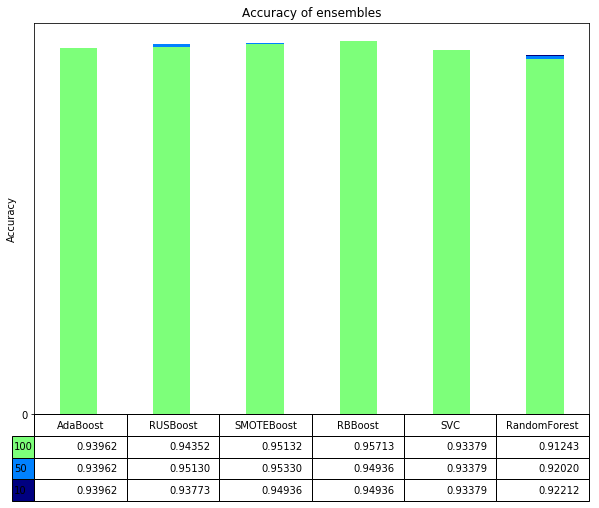

In [122]:
all_acc = np.concatenate((np.array(adaboost_accuracies).mean(axis=1).reshape(-1, 1), 
                          np.array(rusboost_accuracies).mean(axis=1).reshape(-1, 1),
                          np.array(smoteboost_accuracies).mean(axis=1).reshape(-1, 1),
                          np.array(rbboost_accuracies).mean(axis=1).reshape(-1, 1),
                          np.array([np.mean(svc_accuracies), np.mean(svc_accuracies), np.mean(svc_accuracies)]).reshape(-1, 1),
                          np.array(randomforest_accuracies).mean(axis=1).reshape(-1, 1)), axis=1)

columns = ('AdaBoost', 'RUSBoost', 'SMOTEBoost', 'RBBoost', 'SVC', 'RandomForest')
rows = ['100', '50', '10']

n_rows = len(all_acc)
index = np.arange(len(columns)) + 0.3
bar_width = 0.4
y_offset = np.zeros(len(columns))
colors = plt.cm.jet(np.linspace(0, 0.5, len(rows)))
values = np.arange(0, 10, 100)
value_increment = 1

cell_text = []
for row in range(n_rows):
    plt.bar(index, all_acc[row], bar_width, bottom=y_offset, color=colors[row])
    cell_text.append(['%1.5f' % (x) for x in all_acc[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

fig = plt.gcf()
fig.set_size_inches(11,8)
plt.ylabel("Accuracy")
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Accuracy of ensembles')
plt.show()

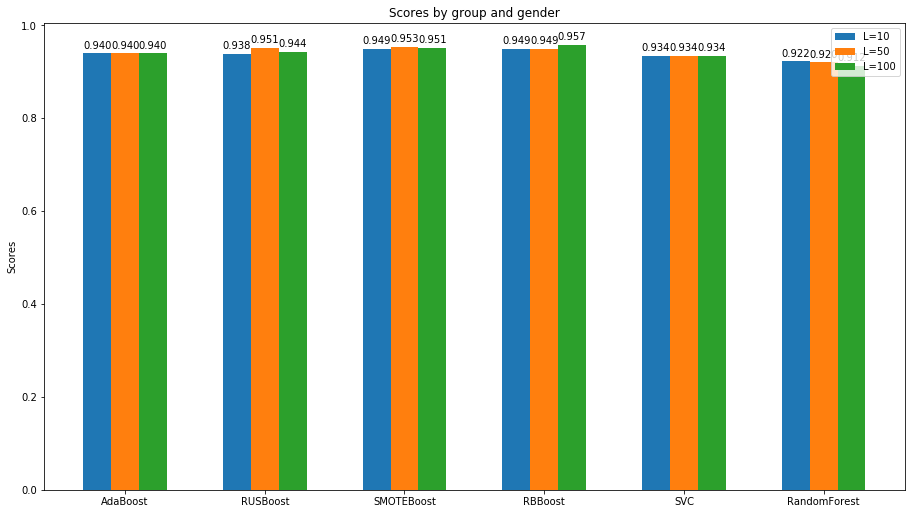

In [145]:
ensemble10 = all_acc[0]
ensemble50 = all_acc[1]
ensemble100 = all_acc[2]

values = np.arange(len(columns))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(values - width, ensemble10, width, label='L=10')
rects2 = ax.bar(values, ensemble50, width, label='L=50')
rects3 = ax.bar(values + width, ensemble100, width, label='L=100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(values)
ax.set_xticklabels(columns)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%0.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(14,8)
plt.show()

In [198]:
all_pr = np.concatenate((np.expand_dims(np.array(adaboost_pr).mean(axis=1), axis=1), 
                          np.expand_dims(np.array(rusboost_pr).mean(axis=1), axis=1),
                          np.expand_dims(np.array(smoteboost_pr).mean(axis=1), axis=1),
                          np.expand_dims(np.array(rbboost_pr).mean(axis=1), axis=1),
                          np.expand_dims(np.array([svc_pr[0], svc_pr[0],svc_pr[0]]).mean(axis=1), axis=1),
                          np.expand_dims(np.array(randomforest_pr).mean(axis=1), axis=1),
                        ), axis=1)
all_pr.shape

(3, 6, 2)

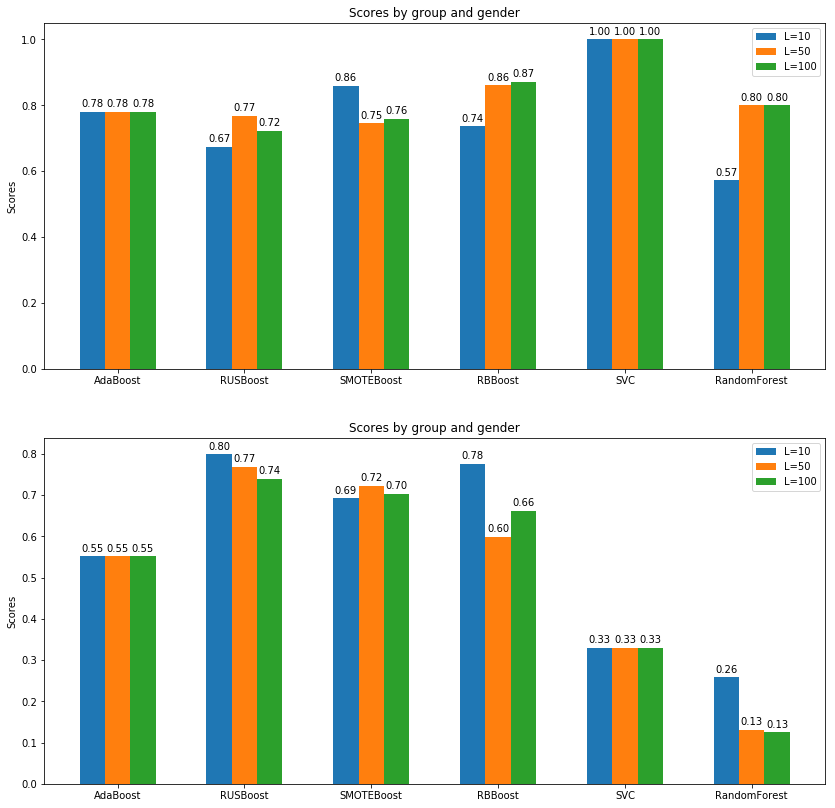

In [208]:
ensemble10_p = all_pr[0,:,0]
ensemble50_p = all_pr[1,:,0]
ensemble100_p = all_pr[2,:,0]

ensemble10_r = all_pr[0,:,1]
ensemble50_r = all_pr[1,:,1]
ensemble100_r = all_pr[2,:,1]

values = np.arange(len(columns))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(2)
rects10 = ax[0].bar(values - width, ensemble10_p, width, label='L=10')
rects20 = ax[0].bar(values, ensemble50_p, width, label='L=50')
rects30 = ax[0].bar(values + width, ensemble100_p, width, label='L=100')

rects11 = ax[1].bar(values - width, ensemble10_r, width, label='L=10')
rects21 = ax[1].bar(values, ensemble50_r, width, label='L=50')
rects31 = ax[1].bar(values + width, ensemble100_r, width, label='L=100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Scores')
ax[0].set_title('Scores by group and gender')
ax[0].set_xticks(values)
ax[0].set_xticklabels(columns)
ax[0].legend()

ax[1].set_ylabel('Scores')
ax[1].set_title('Scores by group and gender')
ax[1].set_xticks(values)
ax[1].set_xticklabels(columns)
ax[1].legend()


def autolabel(rects, i):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[i].annotate('%0.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects10, 0)
autolabel(rects20, 0)
autolabel(rects30, 0)

autolabel(rects11, 1)
autolabel(rects21, 1)
autolabel(rects31, 1)

# fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(14,14)
plt.show()